Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

np.random.seed(32)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM,Conv1D,MaxPooling1D,Dropout
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Reading file and cleaning question body 

In [3]:
df = pd.read_csv('/content/drive/My Drive/BigQuestions.csv')

##Uncomment the specific category you want to classify
df = df[['Body','Tags']]
# df = df[['Body','Tags2']]
# df = df[['Body','Tags3']]

def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]\n\t+')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))


def clean_text(text):
  text = text.lower()
  text = cleanhtml(text)
  text = REPLACE_BY_SPACE_RE.sub(' ',text)
  text = BAD_SYMBOLS_RE.sub('',text)
  text = ' '.join(word for word in text.split() if word not in STOPWORDS)
  return text

df['Body'] = df['Body'].apply(lambda x: clean_text(x))


Converting question body in sequences to feed to neural network

In [4]:
#MAX_NB_WORDS high ==> higher accuracy (overfitting)
#MAX_NB_WORDS low ==> lower accuracy (underfitting)
#Hyperparameter
MAX_NB_WORDS = 50000

#Uncomment the previous selected category 
df = df[df['Tags'].notnull()]
# df = df[df['Tags2'].notnull()]
# df = df[df['Tags3'].notnull()]

#Optional: removing category with low occurences
# df.groupby('Tags').filter(lambda x: len(x) > 4)


#Using Tokenizer for transformation
text = df['Body']

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,char_level=False)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)


#Select target based on previous selected category

target = pd.get_dummies(df['Tags']).values
# target = pd.get_dummies(df['Tags2']).values
# target = pd.get_dummies(df['Tags3']).values

print(target.shape)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

(123175, 1223)
Found 1266334 unique tokens.


Plotting some informations


In [5]:
sequences[0]

[9,
 1054,
 2659,
 100,
 374,
 1577,
 4909,
 31911,
 5924,
 12266,
 5924,
 13706,
 14309,
 25488,
 7092,
 6254,
 3388,
 100,
 1149,
 85,
 28,
 660,
 619,
 1,
 4,
 619,
 660,
 2085,
 660,
 619,
 4,
 619,
 7,
 55,
 4,
 11,
 28,
 695,
 43952,
 11,
 7729,
 1129,
 4,
 619,
 4,
 62,
 40,
 660,
 619,
 630,
 62,
 40,
 24324,
 391]

In [6]:
type(tokenizer.word_index),len(tokenizer.word_index)

(dict, 1266334)

In [7]:
index_to_word = dict((i,w) for w, i in tokenizer.word_index.items())

In [8]:
' '.join([index_to_word[i] for i in sequences[0]])

'want calculate percentage change either increase decrease listhere 203 305 203 455 506 295 134 codedef percent change in try value old num gt new num old elif old num new num 0 else new return value except zerodivisionerror return 0how assign new num new number list old num previous number list abovethanks advance'

In [9]:
seq_lens = [len(s) for s in sequences]
print('average length: %0.1f' % np.mean(seq_lens))
print('max length: %d' % max(seq_lens))

average length: 68.1
max length: 2902


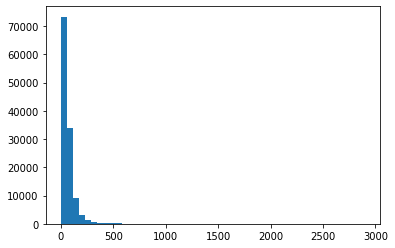

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

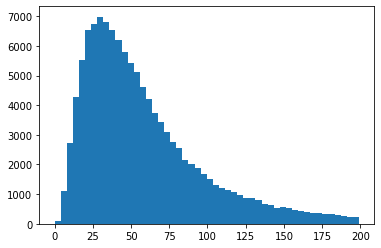

In [11]:
plt.hist([l for l in seq_lens if l < 200], bins=50);

In [13]:
print(df.shape)

df['Tags'].value_counts()

(123175, 2)


javascript         18507
java               15720
c#                 11141
python             10657
php                 7899
                   ...  
j                      1
retro-computing        1
jndi                   1
ria                    1
primes                 1
Name: Tags, Length: 1223, dtype: int64

In [ ]:
df2 = df['Tags'].value_counts().rename_axis('unique_values').reset_index(name='counts')

Application of pad_sequences

In [14]:
#Hyperparameter
MAX_SEQUENCE_LENGTH = 200

# pad sequences with 0s
text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print(text.shape)

(123175, 200)


Splitting data in training and testing sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(text,target,test_size = 0.33)

print(X_train.shape)
print(y_train.shape)

(82527, 200)
(82527, 1223)



Neural network 1: uses a simple Embedding level to take sequences as input and simple level of selection

In [ ]:
from keras.layers import Dense,Input,Flatten
from keras.layers import GlobalAveragePooling1D,Embedding
from keras.models import Model

#Hyperparameter
EMBEDDING_DIM = 75

#Select N_CLASSES based on previous selection
# N_CLASSES = df['Tags'].nunique()
# N_CLASSES = df['Tags2'].nunique()
# N_CLASSES = df['Tags3'].nunique()
print(N_CLASSES)


sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS,EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES,activation='softmax')(average)

model = Model(sequence_input,predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['acc'])


print(model.summary())

In [ ]:
#Change hyperparameter of epochs and batch_size based on results

history = model.fit(X_train,y_train,validation_split=0.1,
          epochs=10,batch_size=128)

Neural network 2: uses LSTM level

In [ ]:
from keras.layers import Dense,Input,Flatten
from keras.layers import GlobalAveragePooling1D,Embedding
from keras.models import Model

#Hyperparameter
EMBEDDING_DIM = 75

#Select N_CLASSES based on previous selection
# N_CLASSES = df['Tags'].nunique()
# N_CLASSES = df['Tags2'].nunique()
# N_CLASSES = df['Tags3'].nunique()
print(N_CLASSES)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_NB_WORDS,EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(x)


model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print(model.summary())

In [ ]:
#Change hyperparameter of epochs and batch_size based on results

history = model.fit(X_train, y_train, validation_split=0.1,
          epochs=10, batch_size=128)

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Best neural network: uses both CNN and LSTM level for maximum learning


In [16]:
from keras.layers import Dense,Input,Flatten
from keras.layers import GlobalAveragePooling1D,Embedding
from keras.models import Model
from keras.callbacks import EarlyStopping

#Hyperparameter
EMBEDDING_DIM = 70

#Select N_CLASSES based on previous selection
N_CLASSES = df['Tags'].nunique()
# N_CLASSES = df['Tags2'].nunique()
# N_CLASSES = df['Tags3'].nunique()
print(N_CLASSES)

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_NB_WORDS,EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
x = Dropout(0.2)(x)
x = LSTM(64)(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print(model.summary())

1223
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 70)           3500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           22464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 39, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 64)            20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 64)       

In [17]:
from keras.callbacks import EarlyStopping

#Hyperparameters
EPOCHS = 10
BATCH_SIZE = 128

history = model.fit(X_train, y_train, validation_split=0.1,
          epochs=EPOCHS, batch_size=BATCH_SIZE,
          callbacks=[
              EarlyStopping(monitor='val_loss',
                            min_delta=0.1,
                            patience=2,
                            verbose=0, 
                            mode='auto')
          ])

Epoch 1/10
581/581 [==============================] - 101s 174ms/step - loss: 3.6402 - acc: 0.1423 - val_loss: 3.5000 - val_acc: 0.1515
Epoch 2/10
581/581 [==============================] - 100s 173ms/step - loss: 3.3550 - acc: 0.1803 - val_loss: 3.1177 - val_acc: 0.2692
Epoch 3/10
581/581 [==============================] - 101s 173ms/step - loss: 2.7395 - acc: 0.3524 - val_loss: 2.5332 - val_acc: 0.4223
Epoch 4/10
581/581 [==============================] - 101s 173ms/step - loss: 2.2689 - acc: 0.4873 - val_loss: 2.2998 - val_acc: 0.4973
Epoch 5/10
581/581 [==============================] - 101s 173ms/step - loss: 1.9401 - acc: 0.5731 - val_loss: 2.1786 - val_acc: 0.5301
Epoch 6/10
581/581 [==============================] - 100s 173ms/step - loss: 1.7085 - acc: 0.6253 - val_loss: 2.1315 - val_acc: 0.5477
Epoch 7/10
581/581 [==============================] - 100s 172ms/step - loss: 1.5282 - acc: 0.6619 - val_loss: 2.1648 - val_acc: 0.5445


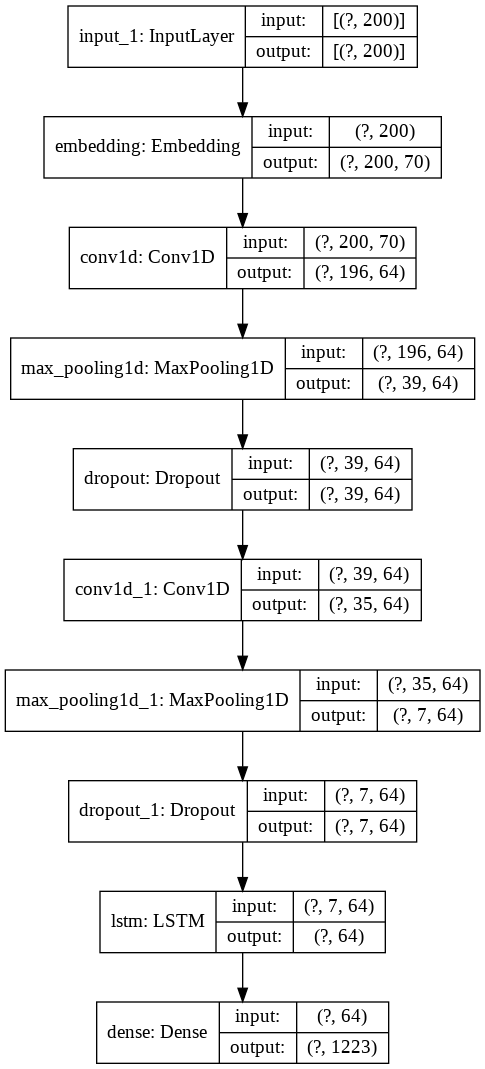

In [18]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)


Evaluation on test set with top 8 categories predicted 

In [19]:
output_test = model.evaluate(X_test,y_test)
print(output_test)

predict_probabilities = model.predict(X_test)

my_accuracy = 0

#Utilizzando i top 8 risultati
for target,array in zip(y_test,predict_probabilities):
  ind = np.argpartition(array, -8)[-8:]
  real_target = np.argmax(target)
  if real_target in ind:
    my_accuracy = my_accuracy + 1


print(my_accuracy/y_test.shape[0])

1271/1271 [==============================] - 15s 12ms/step - loss: 2.1478 - acc: 0.5452
[2.1477792263031006, 0.5452174544334412]
0.8335711474119268


Plotting learning graphics

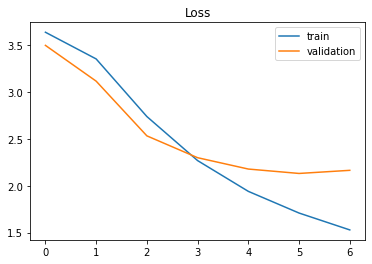

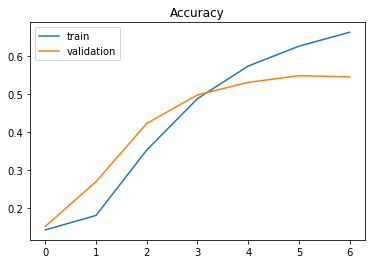

In [20]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show();


plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.show();